# Comparing RNN models on financial data


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Getting the data

In [ ]:
### Pour utiliser sur google colab

import os

from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = '/content/drive/MyDrive/Colab Notebooks/stock-time-series-20050101-to-20171231'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

###  

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.figure(figsize=(20, 5))
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [ ]:
data = dataset[:].iloc[:,1:2].values
test_set.shape

(251, 1)

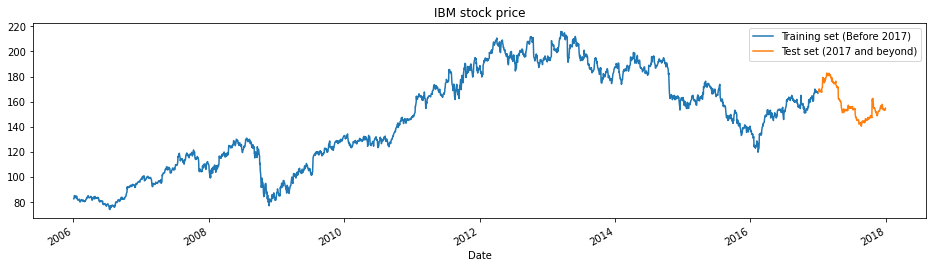

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training and testing set
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 

def preprocess(data):
    output_size = data.shape[0] - 60
    X = np.ndarray((output_size, 60, 1))
    for i in range(output_size):
        X[i, :] = data[i:i+60]
    y = data[60:]
    assert len(X) == len(y)
    return X, y

In [ ]:
X_train, y_train = preprocess(training_set_scaled)
X_test, y_test = preprocess(test_set_scaled)

In [ ]:
print (X_train.shape,y_train.shape,X_test.shape, y_test.shape,training_set[:,0].shape, test_set[:,0].shape)

(2709, 60, 1) (2709, 1) (191, 60, 1) (191, 1) (2769,) (251,)


# Experimental comparison

1. Perform learning and plot the predictions of a few learned models   

2. Extensive comparison

Compare SimpleRNN, GRU NNs, LSTM NNs in terms of performance (mse) vs number of parameters for a variery of models while tryoing to get the best performance for a given budget measured as the number of parameters.

Can you find a clear ranking of the three families of models ? 

3. Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?  
- Implement and test a strategy for testting one step ahead prediction for longer range prediction.
- Design implement and test a model for  learning such a long term prediction task.
     
     

In [ ]:
from keras import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout

Fonctions utiles pour créer les modèles :

In [ ]:
def create_model(units, layer=LSTM, dropout=0, input_shape=(60, 1)):
    model = Sequential()
    model.add(layer(units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse')
    return model

def fit_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train, epochs=5,verbose =0)
    return model.predict(X_test)


# **Learning and predictions plot of a few learned models :**

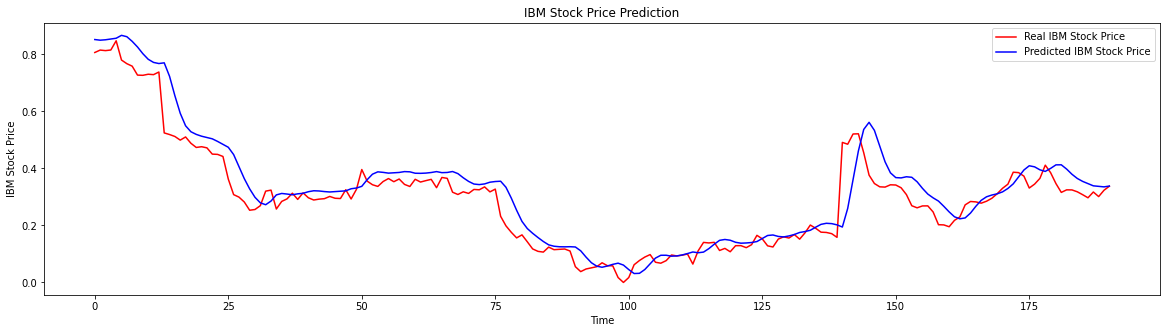

The root mean squared error is 0.06431695334277099.


In [ ]:
# The LSTM architecture
lstm = create_model(128)
y_pred = fit_predict(lstm, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

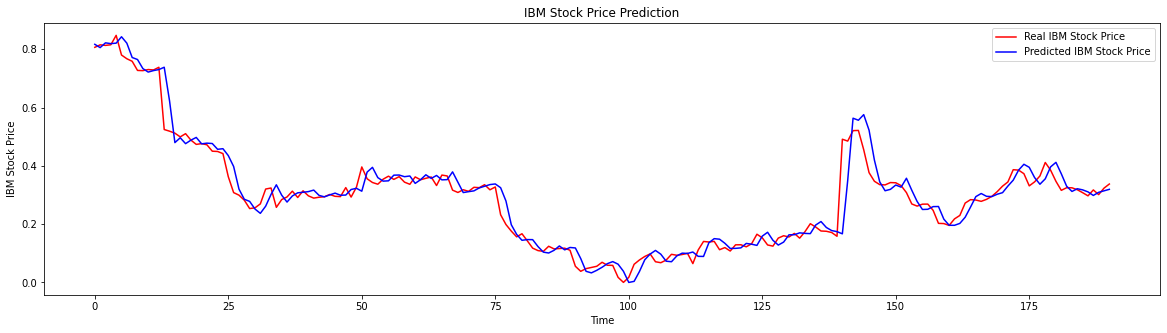

The root mean squared error is 0.04428559337717825.


In [ ]:
# The RNN architecture
rnn = create_model(128,SimpleRNN)
y_pred = fit_predict(rnn, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

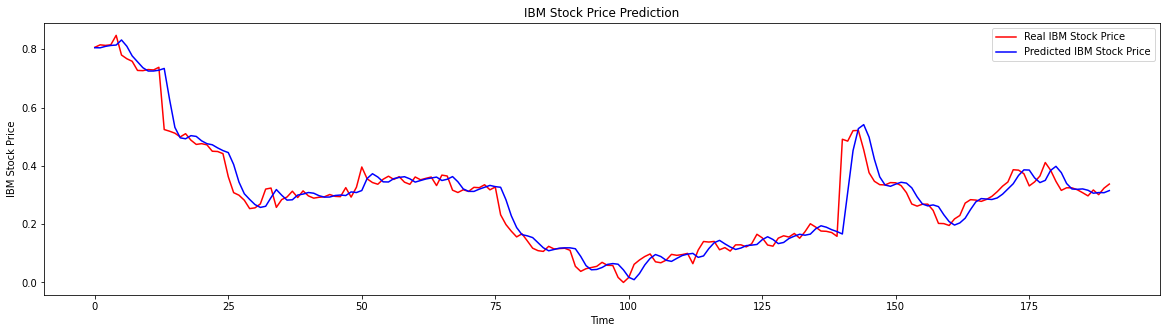

The root mean squared error is 0.04413008965187664.


In [ ]:
# The GRU architecture
gru = create_model(128, GRU)
y_pred = fit_predict(gru, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

*With a dropout layer :*

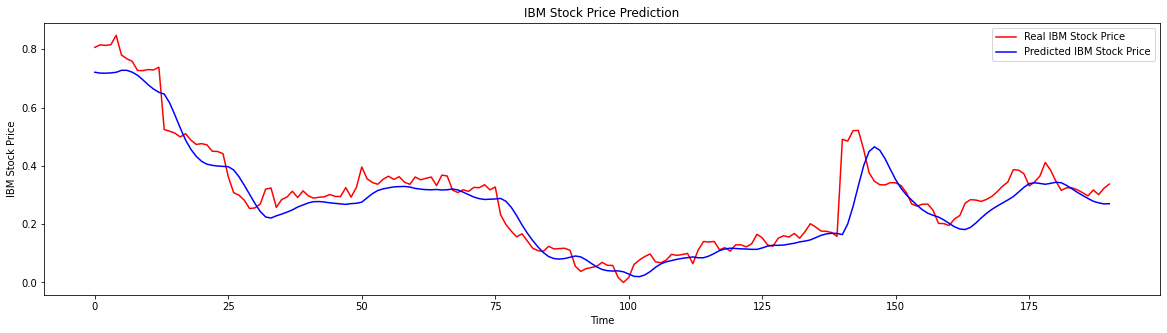

The root mean squared error is 0.06131442414285341.


In [ ]:
# The LSTM architecture with dropout=0.2
lstm = create_model(128, LSTM, dropout=0.2)
y_pred = fit_predict(lstm, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

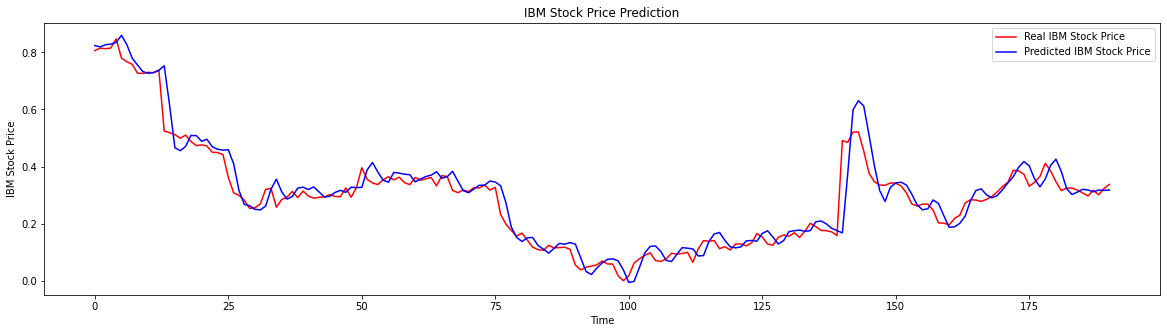

The root mean squared error is 0.04807126758032673.


In [ ]:
# The SimpleRNN architecture with dropout=0.2
rnn = create_model(128, SimpleRNN, dropout=0.2)
y_pred = fit_predict(rnn, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

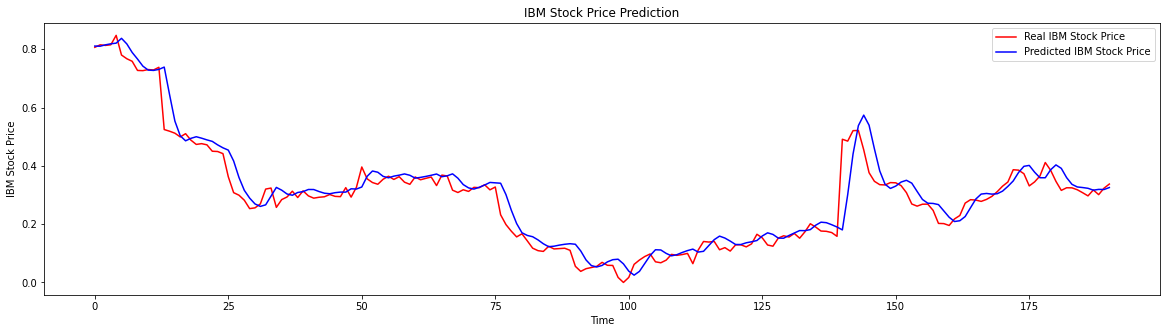

The root mean squared error is 0.04874526072277081.


In [ ]:
# The GRU architecture with dropout=0.2
gru = create_model(128, GRU, dropout=0.2)
y_pred = fit_predict(gru, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

Test avec une couche supplémentaire :

In [ ]:
def create_model2(units, layer=SimpleRNN, dropout=0, input_shape=(60, 1)):
    model = Sequential()
    model.add(layer(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(layer(units, dropout=dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error')
    return model

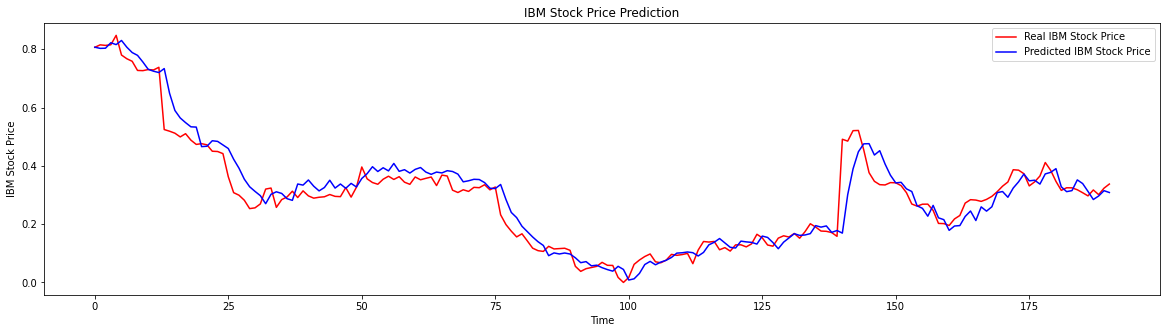

The root mean squared error is 0.05046797452821316.


In [ ]:
rnn = create_model2(128,SimpleRNN, dropout=0.2)
y_pred = fit_predict(rnn, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

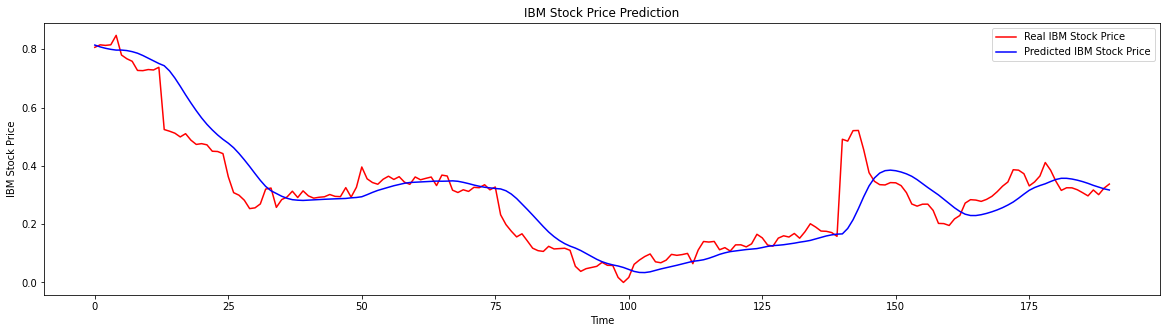

The root mean squared error is 0.07579757572325362.


In [ ]:
lstm = create_model2(128,LSTM, dropout=0.2)
y_pred = fit_predict(lstm, X_train, y_train, X_test)
plot_predictions(y_test,y_pred)
return_rmse(y_test,y_pred)

L'ajout de couche et de drop out ne semble pas améliorer significativement les performances des modèles car on obtient toujours une RMSE proche de 0,05.

On remarque pour chacun des modèle,la courbe de prediction (bleue) est translatée d'une unité de temps vers la droite par rapport à celle réelle (la rouge). On en déduit que les modèles prédisent la valeur du stock price avec un décalage d'un jour.

Essayons un modèle qui prédiraient comme nouvelle valeur du stock price la valeur de la veille : 

(191, 1) (191, 1)


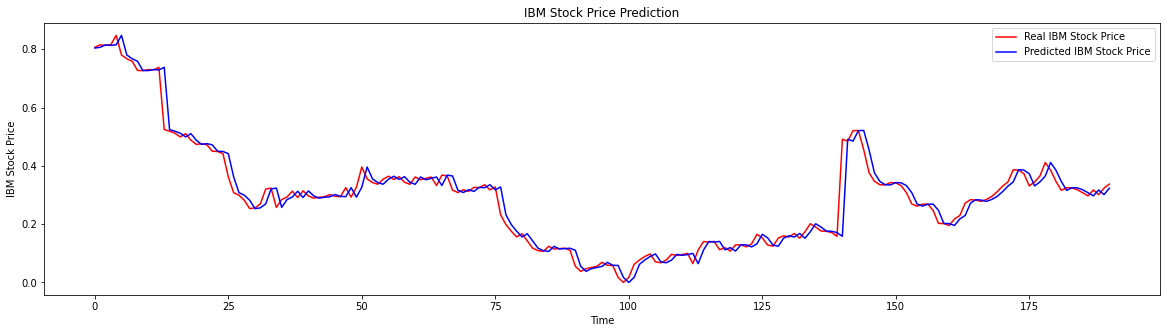

The root mean squared error is 0.03749297897215276.


In [ ]:
y_pred = X_test[:, -1]
print(y_pred.shape,y_test.shape)
plot_predictions(y_test, y_pred)
return_rmse(y_test, y_pred)

On obtient une erreur la plus faible jusqu'à présent ce qui prouve que les modèles utilisés précedemment ne sont pas efficaces. 

## **Extensive comparison**

In [ ]:
def return_rmse2(test, predicted):
    return math.sqrt(mean_squared_error(test, predicted))

On définit une fonction que print les résultats associés à chaque modèle pour chaque nb of units.

In [ ]:
!pip install prettytable==2.0.0

In [ ]:
from prettytable import PrettyTable

dropouts = [0, 0.2, 0.4]

def test_model(model_class, nbs_units):
    results = PrettyTable(['Number of parameters', 'Best dropout', 'MRSE for best dropout'])
    for nb_units in nbs_units:
        dropout_results = []
        for dropout in dropouts:
            print('Testing with {} units and a dropout of {}'.format(nb_units, dropout))
            model = create_model(nb_units, model_class, dropout=dropout)
            rmse = return_rmse2(y_test, fit_predict(model, X_train, y_train, X_test))
            dropout_results.append(rmse)
        best = np.argmin(dropout_results)
        results.add_row([model.count_params(), dropouts[best], dropout_results[best]])
    return results

I chose arbitrary number of units in order to have similar number of parameters for each model. 

In [ ]:
print('---TESTING RNN---')
rnn_results = test_model(SimpleRNN, [16, 32, 64, 128])
print(rnn_results)

---TESTING RNN---
Testing with 16 units and a dropout of 0
Testing with 16 units and a dropout of 0.2
Testing with 16 units and a dropout of 0.4
Testing with 32 units and a dropout of 0
Testing with 32 units and a dropout of 0.2
Testing with 32 units and a dropout of 0.4
Testing with 64 units and a dropout of 0
Testing with 64 units and a dropout of 0.2
Testing with 64 units and a dropout of 0.4
Testing with 128 units and a dropout of 0
Testing with 128 units and a dropout of 0.2
Testing with 128 units and a dropout of 0.4
+----------------------+--------------+-----------------------+
| Number of parameters | Best dropout | MRSE for best dropout |
+----------------------+--------------+-----------------------+
|         305          |      0       |  0.05599522640754968  |
|         1121         |      0       |  0.04688450919313884  |
|         4289         |      0       |  0.03871827252441369  |
|        16769         |     0.2      |  0.04952424076340583  |
+----------------------

In [ ]:
print('---TESTING LSTM---')
lstm_results = test_model(LSTM, [8, 16, 32, 64])
print(lstm_results)

---TESTING LSTM---
Testing with 8 units and a dropout of 0
Testing with 8 units and a dropout of 0.2
Testing with 8 units and a dropout of 0.4
Testing with 16 units and a dropout of 0
Testing with 16 units and a dropout of 0.2
Testing with 16 units and a dropout of 0.4
Testing with 32 units and a dropout of 0
Testing with 32 units and a dropout of 0.2
Testing with 32 units and a dropout of 0.4
Testing with 64 units and a dropout of 0
Testing with 64 units and a dropout of 0.2
Testing with 64 units and a dropout of 0.4
+----------------------+--------------+-----------------------+
| Number of parameters | Best dropout | MRSE for best dropout |
+----------------------+--------------+-----------------------+
|         329          |      0       |   0.0684308335831625  |
|         1169         |      0       |  0.06054847247741067  |
|         4385         |     0.4      |  0.06487034023395549  |
|        16961         |      0       |  0.05527193071903084  |
+----------------------+----

In [ ]:
print('---TESTING GRU---')
gru_results = test_model(GRU, [8, 16, 32, 64])
print(gru_results)

---TESTING GRU---
Testing with 8 units and a dropout of 0
Testing with 8 units and a dropout of 0.2
Testing with 8 units and a dropout of 0.4
Testing with 16 units and a dropout of 0
Testing with 16 units and a dropout of 0.2
Testing with 16 units and a dropout of 0.4
Testing with 32 units and a dropout of 0
Testing with 32 units and a dropout of 0.2
Testing with 32 units and a dropout of 0.4
Testing with 64 units and a dropout of 0
Testing with 64 units and a dropout of 0.2
Testing with 64 units and a dropout of 0.4
+----------------------+--------------+-----------------------+
| Number of parameters | Best dropout | MRSE for best dropout |
+----------------------+--------------+-----------------------+
|         273          |      0       |  0.04606603499992325  |
|         929          |      0       |  0.041624360685317024 |
|         3393         |      0       |  0.04237155293213886  |
|        12929         |      0       |  0.043947263780721064 |
+----------------------+-----

On affiche les meilleures performances de chaque modèle en fonction de son nombre de paramètres (proportionnel au nb of units) :

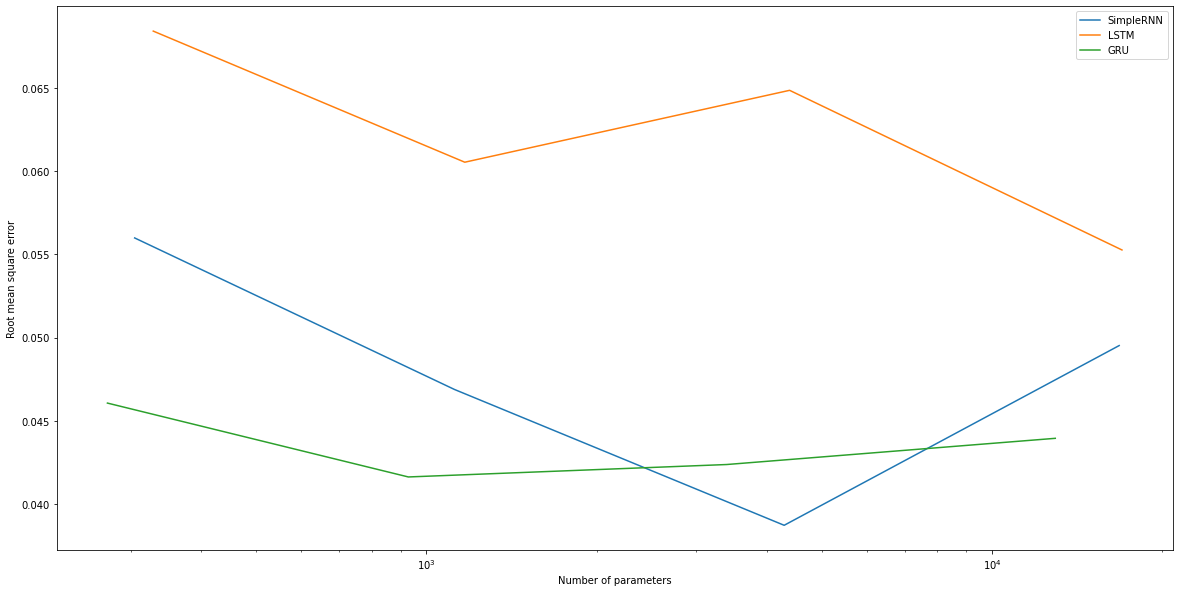

In [ ]:
plt.figure(figsize=(20, 10))

rnn_points = np.array(rnn_results._rows)
plt.plot(rnn_points[:, 0], rnn_points[:, 2], label='SimpleRNN')

lstm_points = np.array(lstm_results._rows)
plt.plot(lstm_points[:, 0], lstm_points[:, 2], label='LSTM')

gru_points = np.array(gru_results._rows)
plt.plot(gru_points[:, 0], gru_points[:, 2], label='GRU')

plt.legend()
plt.xlabel("Number of parameters")
plt.xscale('log')
plt.ylabel("Root mean square error")

plt.show()

On remarque que les modèles GRU et SimpleRNN obtiennent de meilleures résultats.

Les résultats obtenus sont toujours moins bons que ceux donnés par le modèle très simple consistant a prédire à j le stock price de j-1. Cela veut dire que le modèle ne parvient pas à exploiter les données correctement, ce qui explique que la modification des paramêtre et notamment l'ajout de régularisation (drop out) ne modifie pas les performances du modèle.

### Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?

Bien sur, il suffit de changer la dimension de la sortie : on ne veut plus un scalaire mais un vecteur de dimension 7 en sortie. 

Pour modifier la taille de ma sortie, il faudra modifier la couche dense du modèle : Dense(1) --> Dense(7).

Dans un premier temps, il faut modifier y_train et y_test qui ne sont plus des sclaires mais des vecteurs de dimensions 7 (X_train et X_test sont eux inchangés, seul le nombre de données diminue du fait des 6 valeurs de plus à prendre en compte pour chaque y).

In [ ]:
def preprocess2(data):
    output_size = len(data) - 6 - 60
    X = np.ndarray((output_size, 60, 1))
    y = np.ndarray((output_size, 7))
    for i in range(60, len(data) - 6):
        X[i-60, :] = data[i-60:i]
        y[i-60] = data[i:i+7].ravel()
    return X, y

In [ ]:
X_train, y_train = preprocess2(training_set_scaled)
X_test, y_test = preprocess2(test_set_scaled)

In [ ]:
X_test.shape

(185, 60, 1)

In [ ]:
model = Sequential()
model.add(SimpleRNN(32, return_sequences=True, input_shape=(60, 1)))
model.add(SimpleRNN(32))
#model.add(Dropout(0.2))
model.add(Dense(7))
model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error')

In [ ]:
y_pred = fit_predict(model, X_train, y_train, X_test)

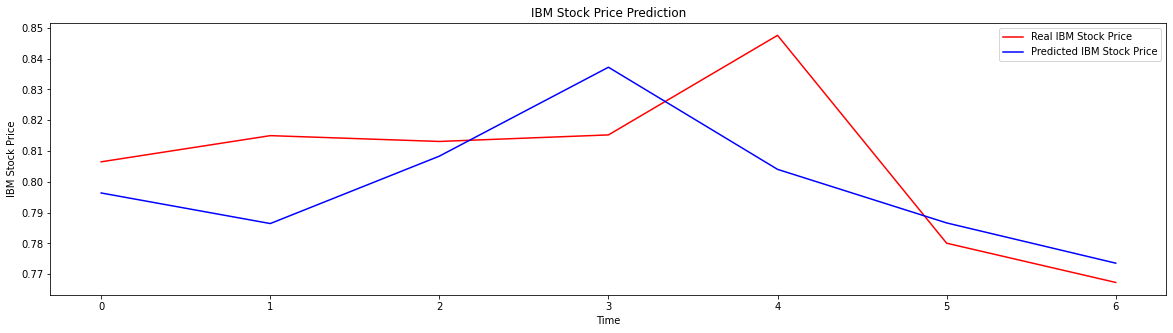

The root mean squared error is 0.0898361041652913.


In [ ]:
plot_predictions(y_test[0], y_pred[0])
print("The root mean squared error is {}.".format(return_rmse(y_test, y_pred)))

Les sorties étant des vecteurs, comparons uniquement une sortie fournit avec ce modèle et sa donnée test associée.

Pour voir si cette nouvelle approche est pertinente, comparons ce modèle avec celui renvoyant la valeur à j-1 au jour j+1,j+2,...,J+7.

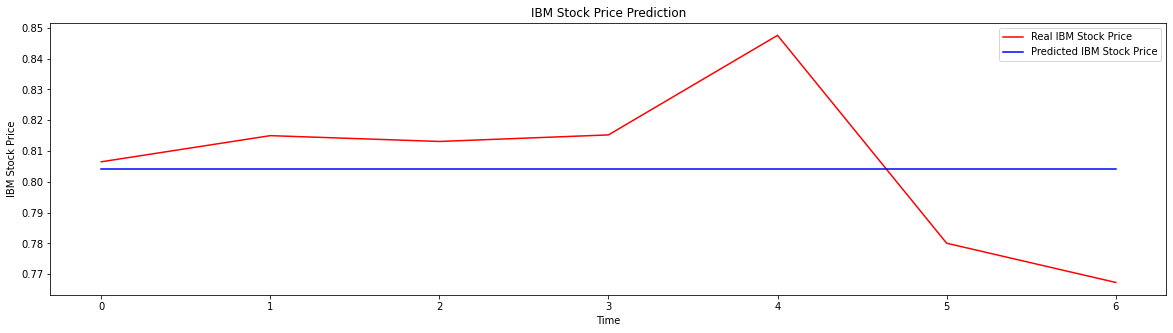

The root mean squared error is 0.07739496452758675.


In [ ]:
y_pred = np.multiply(X_test[:, -1], np.ones((len(X_test), 7)))
plot_predictions(y_test[0], y_pred[0])
print("The root mean squared error is {}.".format(return_rmse(y_test, y_pred)))

On obtient encore des meilleures résultat avec la méthode "bête", ce qui prouve encore une fois que ces modèles RNN ne peuvent pas être fiable dans ce cas particulier de prédiction de stock price.